# t-SNE Analysis of PKS vs non-PKS Molecules

This notebook loads fingerprinted train/val/test splits, combines them,
reduces ECFP4 (2048-bit) to 2D with t-SNE, and plots colored by class (PKS vs non-PKS).

In [7]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

plt.rcParams['lines.linewidth'] = 2
plt.rcParams['figure.dpi'] = 500 # Resolution of figures
plt.rcParams["figure.autolayout"] = True
plt.rcParams["legend.loc"] = 'best'
plt.rcParams['xtick.labelsize']=18
plt.rcParams['ytick.labelsize']=18

# Prefer multicore t-SNE implementations if available
TSNE_IMPL = 'sklearn'
try:
    from MulticoreTSNE import MulticoreTSNE as TSNE_CLASS
    TSNE_IMPL = 'multicore'
except Exception:
    try:
        from openTSNE import TSNE as TSNE_CLASS
        TSNE_IMPL = 'opentsne'
    except Exception:
        from sklearn.manifold import TSNE as TSNE_CLASS
        TSNE_IMPL = 'sklearn'

data_dir = Path('../data')
splits = ['train', 'val', 'test']

def find_split(split):
    candidates = [
        data_dir / split / f'baseline_{split}_ecfp4.parquet',
        data_dir / split / f'baseline_{split}_ecfp4.csv',
        data_dir / split / f'baseline_{split}.parquet',
        data_dir / split / f'baseline_{split}.csv',
    ]
    for p in candidates:
        if p.exists():
            return p
    return None

paths = {s: find_split(s) for s in splits}
paths


{'train': PosixPath('../data/train/baseline_train_ecfp4.parquet'),
 'val': PosixPath('../data/val/baseline_val_ecfp4.parquet'),
 'test': PosixPath('../data/test/baseline_test_ecfp4.parquet')}

In [8]:
# Load and combine
dfs = []
for s, p in paths.items():
    if p is None:
        print(f'Warning: missing split {s}; skipping')
        continue
    if p.suffix == '.parquet':
        df = pd.read_parquet(p)
    else:
        df = pd.read_csv(p)
    df['split'] = s
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)
df_all.shape, df_all['source'].value_counts()


((4045434, 2051),
 bio     2106960
 chem    1925162
 PKS       13312
 Name: source, dtype: int64)

In [3]:
# Prepare features: use ALL PKS + 50,000 sampled non-PKS
fp_cols = [c for c in df_all.columns if str(c).startswith('fp_')]
fp_cols = sorted(fp_cols, key=lambda s: int(str(s).split('_')[1]))
is_pks = (df_all['source'].astype(str) == 'PKS')
df_pks = df_all[is_pks]
df_non = df_all[~is_pks]
NONPKS_MAX = 50000
n_non = min(NONPKS_MAX, len(df_non))
df_non_s = df_non.sample(n_non, random_state=42) if n_non < len(df_non) else df_non
df_sel = pd.concat([df_pks, df_non_s], ignore_index=True)
X = df_sel[fp_cols].to_numpy(dtype=np.float32)
y = (df_sel['source'].astype(str) == 'PKS').astype(int).to_numpy()
df_plot = df_sel.reset_index(drop=True)
X.shape, df_plot['source'].value_counts()


((63312, 2048),
 bio     25973
 chem    24027
 PKS     13312
 Name: source, dtype: int64)

In [5]:
n_jobs = os.cpu_count() or 1
print(f'Using TSNE implementation: {TSNE_IMPL} with n_jobs={n_jobs}')
if TSNE_IMPL == 'multicore':
    tsne = TSNE_CLASS(n_components=2, perplexity=30, learning_rate=200, init='pca', random_state=42, n_jobs=n_jobs, verbose=True)
    emb = tsne.fit_transform(X)
elif TSNE_IMPL == 'opentsne':
    tsne = TSNE_CLASS(n_components=2, perplexity=30, n_jobs=n_jobs, random_state=42, verbose=True, initialization='pca')
    emb = tsne.fit(X)
else:
    tsne = TSNE_CLASS(n_components=2, perplexity=30, learning_rate='auto', init='pca', verbose=1, random_state=42)
    emb = tsne.fit_transform(X)
df_plot['tsne_1'] = emb[:, 0]
df_plot['tsne_2'] = emb[:, 1]
df_plot[['tsne_1', 'tsne_2', 'source']].head()


Using TSNE implementation: sklearn with n_jobs=12
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 63312 samples in 0.148s...
[t-SNE] Computed neighbors for 63312 samples in 23.032s...
[t-SNE] Computed conditional probabilities for sample 1000 / 63312
[t-SNE] Computed conditional probabilities for sample 2000 / 63312
[t-SNE] Computed conditional probabilities for sample 3000 / 63312
[t-SNE] Computed conditional probabilities for sample 4000 / 63312
[t-SNE] Computed conditional probabilities for sample 5000 / 63312
[t-SNE] Computed conditional probabilities for sample 6000 / 63312
[t-SNE] Computed conditional probabilities for sample 7000 / 63312
[t-SNE] Computed conditional probabilities for sample 8000 / 63312
[t-SNE] Computed conditional probabilities for sample 9000 / 63312
[t-SNE] Computed conditional probabilities for sample 10000 / 63312
[t-SNE] Computed conditional probabilities for sample 11000 / 63312
[t-SNE] Computed conditional probabilities for sample 12000 / 63312

,tsne_1,tsne_2,source
0,56.665016,-24.966345,PKS
1,-50.862583,29.356941,PKS
2,-75.999512,-37.488415,PKS
3,-64.530403,20.125084,PKS
4,39.748714,12.604127,PKS


Saved figure to ../data/processed/tsne_pks_vs_nonpks.png


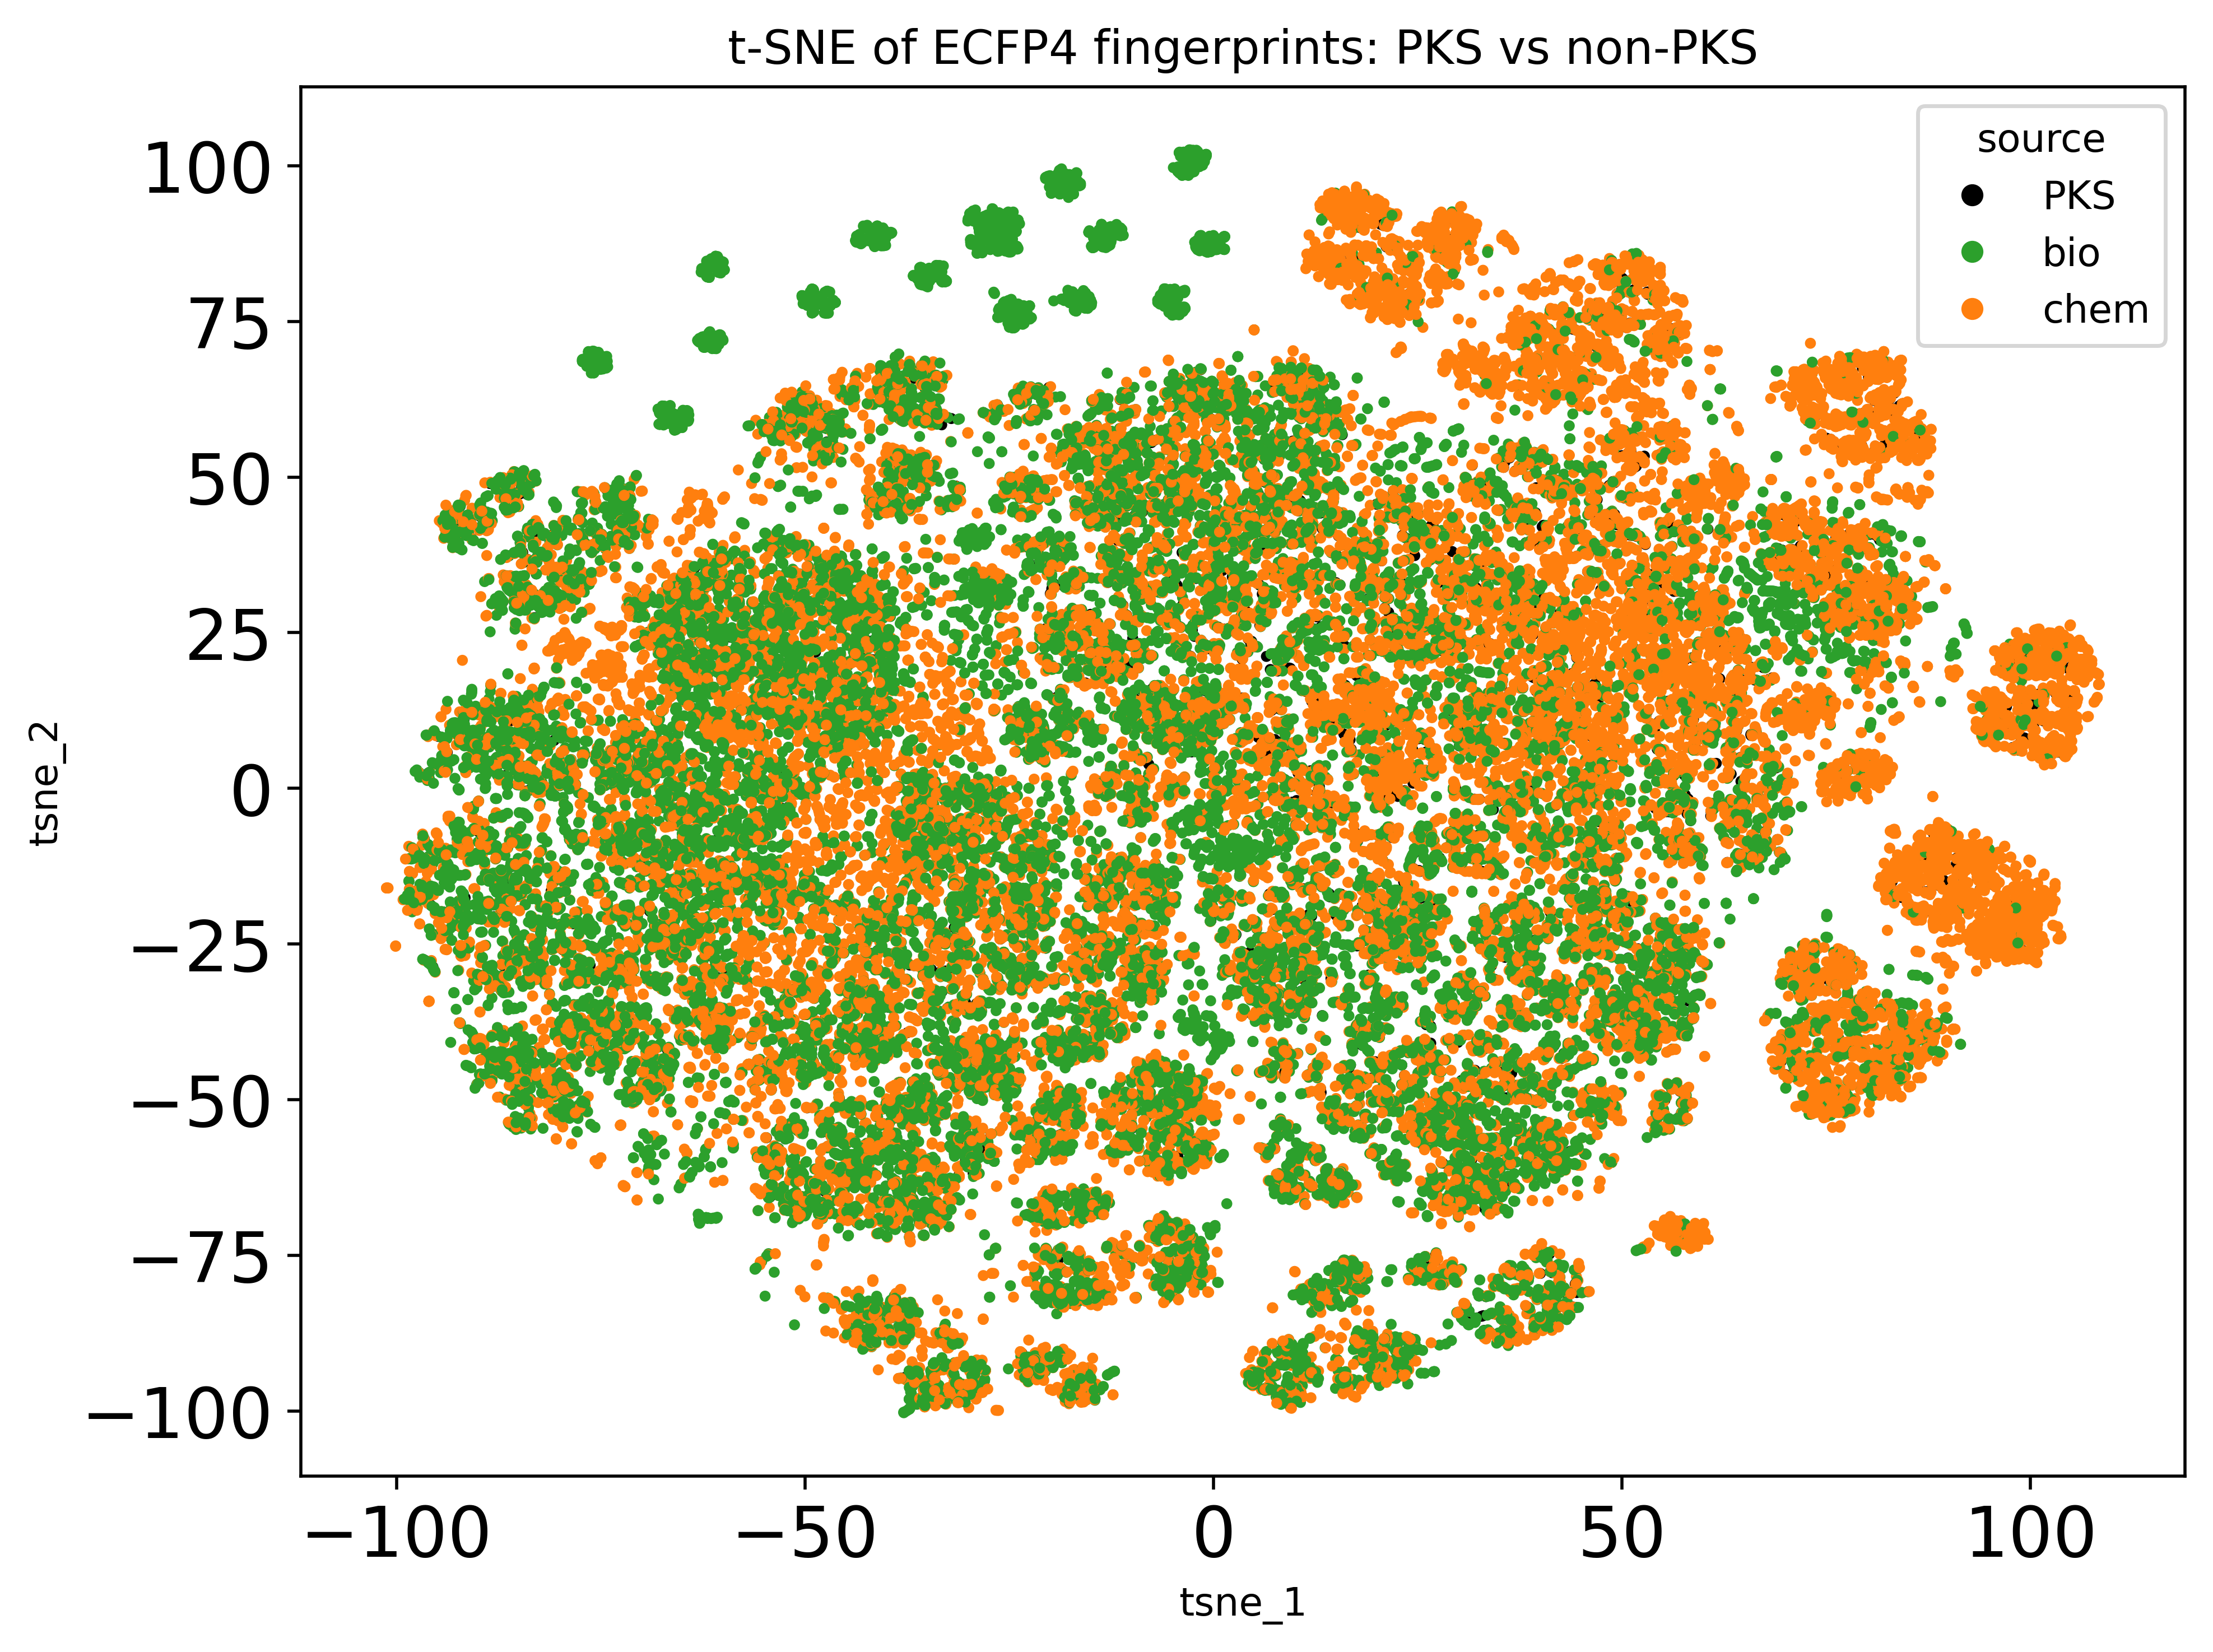

In [12]:
# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_plot, x='tsne_1', y='tsne_2', hue='source',
                palette={'PKS': 'k', 'bio': '#2ca02c', 'chem': '#ff7f0e'},
                alpha=1, s=8, linewidth=0)
plt.title('t-SNE of ECFP4 fingerprints: PKS vs non-PKS')
plt.legend(title='source', markerscale=2)
plt.tight_layout()
out_path = Path('../data/processed/tsne_pks_vs_nonpks.png')
out_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(out_path, dpi=200)
print('Saved figure to', out_path)
plt.show()

In [ ]:
# Alternate plot: overlay PKS in black on top for visibility
import matplotlib.patches as mpatches
sns.set_style('white')
plt.figure(figsize=(9, 7), facecolor='white')
df_non = df_plot[df_plot['source'] != 'PKS']
df_pks = df_plot[df_plot['source'] == 'PKS']
pal_non = {'bio': '#2ca02c', 'chem': '#ff7f0e'}
sns.scatterplot(data=df_non, x='tsne_1', y='tsne_2', hue='source',
                palette=pal_non, alpha=0.6, s=8, linewidth=0, rasterized=True)
plt.scatter(df_pks['tsne_1'], df_pks['tsne_2'], c='k', s=14, alpha=0.9, linewidths=0, zorder=3, label='PKS')
plt.title('t-SNE of ECFP4 fingerprints: PKS vs non-PKS (PKS overlaid in black)', fontsize=13)
legend_handles = [mpatches.Patch(color=pal_non.get('bio', '#2ca02c'), label='bio'),
                   mpatches.Patch(color=pal_non.get('chem', '#ff7f0e'), label='chem'),
                   mpatches.Patch(color='k', label='PKS')]
plt.legend(handles=legend_handles, title='source', markerscale=1.8, frameon=True)
plt.tight_layout()
out_path2 = Path('../data/processed/tsne_pks_vs_nonpks_overlay.png')
out_path2.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(out_path2, dpi=300)
print('Saved overlay figure to', out_path2)
plt.show()
